### Ckecking the GPU :

In [5]:
import tensorflow as tf 

In [6]:
tf.test.is_built_with_cuda()

True

In [7]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1



## Import required libraries :

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
print(tf.__version__)

%matplotlib inline

2.1.0


## Import data :

In [10]:
df=pd.read_csv("C:/Users/Saberi/Downloads/desc.csv")
df.head()
clean_df=df.copy()
clean_df.head()

,image_id,street,city,n_city,bed,bath,sqft,price
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100


In [11]:
clean_df.shape

(15474, 8)

## Cleaning the data :

In [12]:
clean_df.nunique()

image_id    15474
street      12401
city          415
n_city        415
bed            12
bath           32
sqft         3571
price        2320
dtype: int64

*As you can see, we have 12401 unique streets containing zip codes. In order to reduces the unique numbers of streets, we'll omid the zip codes from addresses.*

### Omiting zip codes :

In [13]:
street=clean_df['street'].copy()
for j in range(len(street)):
  res = ''.join([i for i in clean_df['street'][j] if not i.isdigit()])
  street[j]=res
clean_df['street']=street
clean_df.nunique()

image_id    15474
street      10130
city          415
n_city        415
bed            12
bath           32
sqft         3571
price        2320
dtype: int64

*We successfully reduced the unique numbers of streets from 12401 to 10130.*

In [14]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15474 entries, 0 to 15473
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image_id  15474 non-null  int64  
 1   street    15474 non-null  object 
 2   city      15474 non-null  object 
 3   n_city    15474 non-null  int64  
 4   bed       15474 non-null  int64  
 5   bath      15474 non-null  float64
 6   sqft      15474 non-null  int64  
 7   price     15474 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 967.2+ KB


*As you can see we have no null data*

### In this section we are going to use a meta data to cluster cities into counties (major cities) :

In [15]:
### preparing the 'city' column

city=clean_df['city'].copy()

clean_df['city']=city.str.split(',', expand=True)[0]
clean_df['city']=clean_df['city'].apply(lambda x : x.upper())
clean_df.head(4)

,image_id,street,city,n_city,bed,bath,sqft,price
0,0,Van Buren Avenue,SALTON CITY,317,3,2.0,1560,201900
1,1,C Street W,BRAWLEY,48,3,2.0,713,228500
2,2,Clark Road,IMPERIAL,152,3,1.0,800,273950
3,3,Brawley Avenue,BRAWLEY,48,3,1.0,1082,350000


#### Importing meta data :

In [16]:
# A website who has all the California's towns and cities with the corresponding County 

url = 'https://www.corragroup.com/california-county-lookup.html'

dfs = pd.read_html(url)
                                                                                                           
dfc=pd.DataFrame(dfs[0])

dfc=dfc[['City','County']]

dfc.head()

,City,County
0,100 PALMS,IMPERIAL
1,1000 PALMS,RIVERSIDE
2,1ST INTERSTATE BK,LOS ANGELES
3,29 PALMS,SAN BERNARDINO
4,29 PALMS MCB,SAN BERNARDINO


In [17]:
# In California we have 58 counties and 2518 small cities
dfc.nunique()

City      2518
County      58
dtype: int64

In [18]:
#in the house price data frame we have 415 small cities 
clean_df.nunique()

image_id    15474
street      10130
city          415
n_city        415
bed            12
bath           32
sqft         3571
price        2320
dtype: int64

***Our plan is to specify each city's corresponding county.***

In [19]:
#creating a helper boolian variable named country_bool 
my_city=pd.DataFrame(clean_df['city'])
cal_city=dfc['City'].tolist()

clean_df['County_bool']=my_city.isin(cal_city)


In [20]:
clean_df.head(4)

,image_id,street,city,n_city,bed,bath,sqft,price,County_bool
0,0,Van Buren Avenue,SALTON CITY,317,3,2.0,1560,201900,True
1,1,C Street W,BRAWLEY,48,3,2.0,713,228500,True
2,2,Clark Road,IMPERIAL,152,3,1.0,800,273950,True
3,3,Brawley Avenue,BRAWLEY,48,3,1.0,1082,350000,True


*Extract the corresponding counties of each city from the meta-data :*

In [21]:
county=[]
for i in range(len(clean_df)):
  if clean_df['County_bool'][i]:
    county.append(np.array( dfc['County'][ dfc['City']==clean_df['city'][i] ] )[0])
  else:
    county.append('null')

clean_df['county']=county
clean_df.head(4)


,image_id,street,city,n_city,bed,bath,sqft,price,County_bool,county
0,0,Van Buren Avenue,SALTON CITY,317,3,2.0,1560,201900,True,IMPERIAL
1,1,C Street W,BRAWLEY,48,3,2.0,713,228500,True,IMPERIAL
2,2,Clark Road,IMPERIAL,152,3,1.0,800,273950,True,IMPERIAL
3,3,Brawley Avenue,BRAWLEY,48,3,1.0,1082,350000,True,IMPERIAL


*Checking the new county variable :*

In [22]:
# There are 256 null values and it means that the cooresponding counties of some cities were not in the meta-data
clean_df['county'].value_counts()

RIVERSIDE          3134
LOS ANGELES        2732
SAN DIEGO          2705
SAN BERNARDINO     2579
ORANGE             1675
SAN LUIS OBISPO     957
VENTURA             951
KERN                316
null                256
SANTA BARBARA       149
IMPERIAL             20
Name: county, dtype: int64

*As you can see, we have 256 null values, and we should modify them.*

*Let's check which cities' corresponding county was not found on the meta-data :*

In [23]:
#number of cities that we failed to allocate a county to

clean_df[clean_df['county']=='null']['city'].nunique()

12

In [24]:
#list of cities that we failed to allocate a county to
clean_df[clean_df['county']=='null']['city'].unique()

array(['VALLEY GLEN', 'VAL VERDE', 'LAKE BALBOA', 'LAKEVIEW TERRACE',
       'LADERA RANCH', 'NORTH TUSTIN', 'LAGUNA WOODS', 'WHITEWATER',
       'OAK GLEN', 'OAK HILLS', 'EL MIRAGE', 'LA CONCHITA'], dtype=object)

***We are going to manually find each of the above cities' corresponding county. After that we'll overwrite the null values with proper counties.***

In [25]:
clean_df.loc[clean_df['city']=='VALLEY GLEN','county']='LOS ANGELES'
clean_df.loc[clean_df['city']=='VAL VERDE','county']='LOS ANGELES'
clean_df.loc[clean_df['city']=='LAKE BALBOA','county']='LOS ANGELES'
clean_df.loc[clean_df['city']=='LAKEVIEW TERRACE','county']='LOS ANGELES'
clean_df.loc[clean_df['city']=='LADERA RANCH','county']='ORANGE'
clean_df.loc[clean_df['city']=='NORTH TUSTIN','county']='ORANGE'
clean_df.loc[clean_df['city']=='LAGUNA WOODS','county']='ORANGE'
clean_df.loc[clean_df['city']=='WHITEWATER','county']='RIVERSIDE'
clean_df.loc[clean_df['city']=='OAK GLEN','county']='SAN BERNARDINO'
clean_df.loc[clean_df['city']=='OAK HILLS','county']='SAN BERNARDINO'
clean_df.loc[clean_df['city']=='EL MIRAGE','county']='SAN BERNARDINO'
clean_df.loc[clean_df['city']=='LA CONCHITA','county']='VENTURA'

In [26]:
clean_df['county'].value_counts()

RIVERSIDE          3138
LOS ANGELES        2747
SAN DIEGO          2705
SAN BERNARDINO     2617
ORANGE             1872
SAN LUIS OBISPO     957
VENTURA             953
KERN                316
SANTA BARBARA       149
IMPERIAL             20
Name: county, dtype: int64

**As you can see, we have no null value and we have 10 different districts in California.**

_____________

In [27]:
### converting columns with integer values to columns with float values
clean_df['bed']=clean_df['bed']/1.
clean_df['sqft']=clean_df['sqft']/1.
clean_df['price']=clean_df['price']/1.

In [28]:
clean_df.describe()

,image_id,n_city,bed,bath,sqft,price
count,15474.000000,15474.000000,15474.000000,15474.000000,15474.000000,1.547400e+04
mean,7736.500000,216.597518,3.506398,2.453251,2173.913209,7.031209e+05
std,4467.103368,112.372985,1.034838,0.958742,1025.339617,3.769762e+05
min,0.000000,0.000000,1.000000,0.000000,280.000000,1.950000e+05
25%,3868.250000,119.000000,3.000000,2.000000,1426.000000,4.450000e+05
50%,7736.500000,222.500000,3.000000,2.100000,1951.000000,6.390000e+05
75%,11604.750000,315.000000,4.000000,3.000000,2737.750000,8.349750e+05
max,15473.000000,414.000000,12.000000,36.000000,17667.000000,2.000000e+06


***The data needs some cleaning! for example the maximum number of baths and bedrooms needs to be checked.***

***Let's split half bathrooms from full bathrooms :***

In [29]:
clean_df['half_bath']=( clean_df['bath']-np.floor(clean_df['bath']) )/0.1
clean_df['bath']=np.floor(clean_df['bath'])
clean_df.head()

,image_id,street,city,n_city,bed,bath,sqft,price,County_bool,county,half_bath
0,0,Van Buren Avenue,SALTON CITY,317,3.0,2.0,1560.0,201900.0,True,IMPERIAL,0.0
1,1,C Street W,BRAWLEY,48,3.0,2.0,713.0,228500.0,True,IMPERIAL,0.0
2,2,Clark Road,IMPERIAL,152,3.0,1.0,800.0,273950.0,True,IMPERIAL,0.0
3,3,Brawley Avenue,BRAWLEY,48,3.0,1.0,1082.0,350000.0,True,IMPERIAL,0.0
4,4,R Carrillo Court,CALEXICO,55,4.0,3.0,2547.0,385100.0,True,IMPERIAL,0.0


### One-hot encoding the county variable & dropping useless variables :

*Although we reduced the number of streets but one-hot endocing of it will produce about 10,000 variables and I do not believe that training a network with more than 10,000 outputs and 15,000 data would be intuitive.*

In [30]:
### creating one-hot variables
county=pd.get_dummies(clean_df["county"])
city=pd.get_dummies(clean_df["city"])
### froping the redundant variables and adding the one-hot encoded ones
clean_df=clean_df.drop([ 'image_id' , 'street' , 'city' , 'n_city' ,'County_bool','county'] ,axis=1)
clean_df=pd.concat([clean_df,county,city],axis=1)

clean_df

,bed,bath,sqft,price,half_bath,IMPERIAL,KERN,LOS ANGELES,ORANGE,RIVERSIDE,...,WILDOMAR,WILMINGTON,WINCHESTER,WINNETKA,WOFFORD HEIGHTS,WOODLAND HILLS,WRIGHTWOOD,YORBA LINDA,YUCAIPA,YUCCA VALLEY
0,3.0,2.0,1560.0,201900.0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.0,2.0,713.0,228500.0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,1.0,800.0,273950.0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,1.0,1082.0,350000.0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.0,3.0,2547.0,385100.0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15469,5.0,4.0,4092.0,949000.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15470,5.0,3.0,2773.0,949900.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15471,3.0,2.0,1576.0,920000.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15472,4.0,2.0,2086.0,997000.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Sanity check of the data :

#### Checking the bathroom column :

In [31]:
continuous=['bed','bath','sqft','price','half_bath']

#sorting the data frame regarding to number of bathrooms from maximum to minimum
clean_df[continuous].sort_values('bath',ascending=False)

,bed,bath,sqft,price,half_bath
714,4.0,36.0,1229.0,240000.0,0.0
778,4.0,13.0,1836.0,299000.0,0.0
13568,11.0,11.0,6600.0,1550000.0,2.0
7531,5.0,8.0,3989.0,795000.0,1.0
5142,6.0,8.0,5883.0,1795000.0,1.0
...,...,...,...,...,...
5686,3.0,0.0,2009.0,281000.0,0.0
9365,3.0,0.0,1648.0,450000.0,0.0
14089,3.0,0.0,980.0,709900.0,1.0
3639,3.0,0.0,1300.0,399000.0,0.0


*First two rows do not have the sensible number of baths regarding other variables. Also, I've checked the corresponding pictures and most certainly those pictures do not contain these nunbers of bathrooms.*

In [32]:
### dropping the entire row of records with unacceptable number of bathrooms
clean_df=clean_df.drop([714,778],axis=0)

#### Checking the sqft column :

In [33]:
#sorting the data frame regarding to the area of each house from minimum to maximum
clean_df[continuous].sort_values('sqft',ascending=True).head(4)

,bed,bath,sqft,price,half_bath
4993,3.0,3.0,280.0,1184000.0,0.0
2037,1.0,1.0,352.0,560000.0,0.0
13674,1.0,1.0,352.0,439000.0,0.0
15250,1.0,1.0,352.0,699000.0,0.0


*The first row's sqft is not right. 280sqft is equals to 26m2 and according to other features of this property like number of bedrooms and bathrooms, amount of price and it's corresponding picture, it should be 2800sqft. So, we'll correct the typo.*

In [34]:
clean_df.loc[4993,'sqft']=2800

#### checking the bed column :

In [35]:
#sorting the data frame regarding to the number of bedrooms from maximum to minimum
clean_df[continuous].sort_values('bed',ascending=False).head(20)

,bed,bath,sqft,price,half_bath
13152,12.0,3.0,2900.0,869500.0,0.0
13568,11.0,11.0,6600.0,1550000.0,2.0
10728,10.0,6.0,3926.0,1250000.0,0.0
14687,10.0,5.0,3284.0,1150000.0,0.0
272,10.0,8.0,3784.0,475000.0,0.0
10926,10.0,5.0,3554.0,1875000.0,0.0
12902,10.0,3.0,1890.0,769500.0,0.0
14533,10.0,4.0,4000.0,1300000.0,0.0
5163,9.0,5.0,6020.0,1875000.0,1.0
8292,9.0,8.0,17667.0,1999888.0,0.0


*By checking the corresponding price and images, it seems that there are no anomalies in number of bedrooms.*

## Importing and cleaning the image data:

*After browsing through the data, I found that there are some pictures that are from the geographic maps, paper-based architecture maps or air maps, and are not compatible with the rest of the pictures. In the below sections, we are going to specify them and will not load them in our training images.*

In [36]:
###map-pics
a=[0,373,380,477,490,482,550,717,747,752,784,889,903,1128,1208,1312,1697,1725,1908,2026,
   2206,2385,2554,2662,2729,3151,3545,4923,4925,4926,4927,4928,4929,4936,4949,5013,5037,5062,5117,5118,
   5119,5120,5121,5124,5129,5134,5135,5136,5177,5180,5312,5313,5368,5413,5510,5511,5530,5533,5551,5591,
   5640,5648,5657,5705,5712,5713,5719,5720,5725,5744,5757,5782,5833,5862,5906,5913,5924,5925,5934,5935,
   5941,5942,5953,6000,6108,6109,6114,6115,6142,6165,6304,6305,6306,6322,6483,6488,6489,6502,6503,6506,
   6509,6510,6511,6526,6649,6672,6697,6698,6699,6701,6714,6770,6835,6836,6854,6872,6873,6893,6895,6948,
   6969,6992,7029,7033,7037,7039,7065,7090,7093,7108,7144,7162,7163,7193,7291,7297,7321,7333,7336,7484,
   7485,7493,7496,7518,7523,7526,7535,7542,7677,7678,7681,7682,7685,7736,7743,7751,7816,7874,7876,7877,
   7888,7907,7969,8238,8709,8809,8895,9492,10488,10609,11821,11822,11998,12024,12623,14476,14481,14599,
   14875]

###air maps
b=[989,1632,1795,1856,2291,4618,7638]

###paper-based architecture maps

c=[2845,3938,4089,4090,7096,9841,9987,11114,12380]

###two records that we've deleted from the numeric data
d=[714,778]

noise_pics=a+b+c+d


In [37]:
len(noise_pics)

197

*Let's read images except those that are on the "noise_pics" list or have 4 channels(corrupted pictures)*

In [38]:
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image


x_img=[]
omit_index=[]

for i in range(0,len(df)):
    if i in noise_pics:
      continue
 
    image = Image.open(f"C:/Users/Saberi/Downloads/pics/pics/{i}.jpg").resize((64,64))
    if img_to_array(image).shape[2]!=3:
        print(f"image {i}.jpg has been omitted")
        omit_index.append(i)
        continue 
    x_img.append(img_to_array(image))
    

image 14.jpg has been omitted
image 2600.jpg has been omitted
image 3747.jpg has been omitted
image 4754.jpg has been omitted
image 5524.jpg has been omitted
image 5728.jpg has been omitted
image 8886.jpg has been omitted
image 9081.jpg has been omitted
image 9194.jpg has been omitted
image 10000.jpg has been omitted
image 12498.jpg has been omitted


In [39]:
###original number of records were 15747
print(len(x_img))
print(len(omit_index))
print(clean_df.shape)

15266
11
(15472, 430)


*Creating a numeric dataset that matches the images :*

In [40]:
###create a list from the omited images except index 714,778 that are already have been omited from clean_df
deleted_index=omit_index+a+b+c
clean_df2=clean_df.drop(deleted_index,axis=0)

clean_df2.shape

(15266, 430)

### Scaling data

In [41]:
clean_df2.head()

,bed,bath,sqft,price,half_bath,IMPERIAL,KERN,LOS ANGELES,ORANGE,RIVERSIDE,...,WILDOMAR,WILMINGTON,WINCHESTER,WINNETKA,WOFFORD HEIGHTS,WOODLAND HILLS,WRIGHTWOOD,YORBA LINDA,YUCAIPA,YUCCA VALLEY
1,3.0,2.0,713.0,228500.0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,1.0,800.0,273950.0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,1.0,1082.0,350000.0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.0,3.0,2547.0,385100.0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,3.0,1.0,1082.0,350000.0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Scaling numeric data :

In [42]:
max_price=max(clean_df2['price'])

In [43]:
cs = MinMaxScaler()

countinuous=['bed','bath','sqft','half_bath']

clean_df2[countinuous] = cs.fit_transform(clean_df2[countinuous])

clean_df2['price']=clean_df2['price']/max(clean_df2['price'])

clean_df2.head()

,bed,bath,sqft,price,half_bath,IMPERIAL,KERN,LOS ANGELES,ORANGE,RIVERSIDE,...,WILDOMAR,WILMINGTON,WINCHESTER,WINNETKA,WOFFORD HEIGHTS,WOODLAND HILLS,WRIGHTWOOD,YORBA LINDA,YUCAIPA,YUCCA VALLEY
1,0.181818,0.181818,0.020849,0.114250,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.181818,0.090909,0.025874,0.136975,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.181818,0.090909,0.042160,0.175000,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.272727,0.272727,0.126769,0.192550,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0.181818,0.090909,0.042160,0.175000,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Scaling image data :

In [44]:
gray_x_img=np.array(tf.image.rgb_to_grayscale(x_img))

In [45]:
gray_x_img=gray_x_img/255.

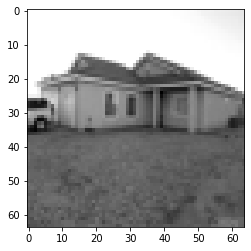

In [46]:
### plotting picture number 22 
plt.imshow(gray_x_img[22,:,:,0],cmap='gray')
plt.show()

In [47]:
clean_df2=clean_df2.reset_index()

In [48]:
clean_df2=clean_df2.drop(['index'],axis=1)

In [49]:
clean_df2.head()

,bed,bath,sqft,price,half_bath,IMPERIAL,KERN,LOS ANGELES,ORANGE,RIVERSIDE,...,WILDOMAR,WILMINGTON,WINCHESTER,WINNETKA,WOFFORD HEIGHTS,WOODLAND HILLS,WRIGHTWOOD,YORBA LINDA,YUCAIPA,YUCCA VALLEY
0,0.181818,0.181818,0.020849,0.114250,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.181818,0.090909,0.025874,0.136975,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.181818,0.090909,0.042160,0.175000,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.272727,0.272727,0.126769,0.192550,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.181818,0.090909,0.042160,0.175000,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


*now our data frame and images have matching indexes*

In [50]:
print(clean_df2.shape)
print(gray_x_img.shape)

(15266, 430)
(15266, 64, 64, 1)


### Test/Train split :

In [51]:
###creating test and train data frames
df_train=clean_df2.sample(frac=0.93,replace=False) #,random_state=15
df_test=clean_df2.drop(df_train.index)
###creating test and train image inputs
train_x_img_gray=gray_x_img[(df_train.index),:,:,:]
test_x_img_gray=gray_x_img[(df_test.index),:,:,:]



In [52]:
### creating test and train outputs
train_y=df_train['price']
test_y=df_test['price']
###creating test and train numeric/one-hot inputs
train_x=df_train.drop(['price'],axis=1)
test_x=df_test.drop(['price'],axis=1)

In [53]:
print(train_x.shape)
print(train_x_img_gray.shape)
print(train_y.shape)

print(test_x.shape)
print(test_x_img_gray.shape)
print(test_y.shape)

(14197, 429)
(14197, 64, 64, 1)
(14197,)
(1069, 429)
(1069, 64, 64, 1)
(1069,)


In [54]:
train_x.head(5)

,bed,bath,sqft,half_bath,IMPERIAL,KERN,LOS ANGELES,ORANGE,RIVERSIDE,SAN BERNARDINO,...,WILDOMAR,WILMINGTON,WINCHESTER,WINNETKA,WOFFORD HEIGHTS,WOODLAND HILLS,WRIGHTWOOD,YORBA LINDA,YUCAIPA,YUCCA VALLEY
14150,0.181818,0.181818,0.060237,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3523,0.090909,0.181818,0.034190,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5944,0.363636,0.272727,0.157667,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
15068,0.272727,0.272727,0.094485,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6503,0.272727,0.272727,0.144961,0.0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


## Start training

***First, we'll fit a fully connected network based on our numeric data; then we'll fit a merged network of FC and CNN to see whether the images will help us predict better or not.***

#### Import required modules

In [55]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout , Concatenate, Input , BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model

In [56]:
def plot_model(history):
    df=pd.DataFrame(history.history)
    plt.plot(df['val_loss'])
    plt.plot(df['loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['validation loss','training loss'], loc='upper right')
    plt.title('Loss of train/validation sets vs Epochs')
    plt.show()

***Trying FC alone***

with 429 input variables including cities

In [57]:
### Regression by a fully connected network
input_model_1 = Input(train_x.shape[1])

model_1=Dense(256,activation='tanh')(input_model_1)
model_1=Dropout(0.1)(model_1)
model_1=BatchNormalization()(model_1)

model_1=Dense(128,activation='tanh')(model_1)
model_1=BatchNormalization()(model_1)

model_1=Dense(32,activation='tanh')(model_1)
model_1=BatchNormalization()(model_1)

model_1=Dense(16,activation='tanh')(model_1)
model_1=BatchNormalization()(model_1)

output=Dense(1,activation='linear')(model_1)

model_1=Model(inputs=input_model_1,outputs=output)
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 429)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               110080    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128  

In [58]:
model_1.compile(optimizer='adam', loss='mse')

history_1 = model_1.fit(x =train_x, y = train_y,batch_size =32,epochs=30,validation_split = 0.1,verbose=1)

Train on 12777 samples, validate on 1420 samples
Epoch 1/30
12777/12777 [==============================] - 3s 222us/sample - loss: 0.0971 - val_loss: 0.0228
Epoch 2/30
12777/12777 [==============================] - 2s 127us/sample - loss: 0.0269 - val_loss: 0.0174
Epoch 3/30
12777/12777 [==============================] - 2s 127us/sample - loss: 0.0214 - val_loss: 0.0152
Epoch 4/30
12777/12777 [==============================] - 2s 128us/sample - loss: 0.0176 - val_loss: 0.0136
Epoch 5/30
12777/12777 [==============================] - 2s 127us/sample - loss: 0.0163 - val_loss: 0.0128
Epoch 6/30
12777/12777 [==============================] - 2s 128us/sample - loss: 0.0152 - val_loss: 0.0129
Epoch 7/30
12777/12777 [==============================] - 2s 127us/sample - loss: 0.0143 - val_loss: 0.0129
Epoch 8/30
12777/12777 [==============================] - 2s 132us/sample - loss: 0.0133 - val_loss: 0.0125
Epoch 9/30
12777/12777 [==============================] - 2s 128us/sample - loss: 0.013

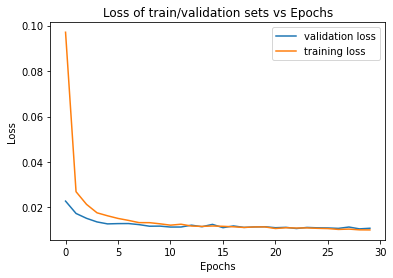

In [59]:
plot_model(history_1)


In [60]:
model_1.evaluate(test_x,test_y)

1069/1069 [==============================] - 0s 44us/sample - loss: 0.0134


0.013419862279896708

In [61]:
test_y.iloc[[74,31,23,426,200]]*max_price

1089     300000.0
448      998000.0
375     1150000.0
6251     490000.0
2919     999999.0
Name: price, dtype: float64

In [62]:
model_1.predict(test_x)[[74,31,23,426,200]]*max_price

array([[ 321093.7 ],
       [1033967.1 ],
       [ 670869.75],
       [ 542481.8 ],
       [1146654.6 ]], dtype=float32)

____________

______________

***Merged Model***

In [63]:
###model 1 is CNN branch
input_model_cnn= Input( (train_x_img_gray.shape[1:]) )

model_cnn=Conv2D(8,(5,5),activation='relu', padding='valid',name='conv_1')(input_model_cnn)
model_cnn=BatchNormalization()(model_cnn)
model_cnn=Dropout(0.1)(model_cnn)
model_cnn=MaxPooling2D(pool_size=(3,3))(model_cnn)

model_cnn=Conv2D(16,(3,3),activation='relu', padding='valid',name='conv_2')(model_cnn)
model_cnn=MaxPooling2D(pool_size=(2,2))(model_cnn)

model_cnn=Conv2D(32,(3,3),activation='relu',padding='valid',name='conv_3')(model_cnn)
model_cnn=MaxPooling2D(pool_size=(2,2))(model_cnn)

model_cnn=Conv2D(64,(3,3),activation='relu',padding='valid',name='conv_4')(model_cnn)
model_cnn=Flatten()(model_cnn)
model_cnn=Dropout(0.1)(model_cnn)

In [64]:
input_model_fc = Input(train_x.shape[1])

model_fc=Dense(128,activation='tanh')(input_model_fc)
model_fc=Dropout(0.1)(model_fc)
model_fc=Dense(84,activation='tanh')(model_fc)
model_fc=Dense(64,activation='tanh')(model_fc)
model_fc=Dropout(0.1)(model_fc)

In [65]:
input_comb_model=Concatenate()([model_cnn,model_fc])

comb_model=Dense(64,activation='relu')(input_comb_model)


comb_model=Dense(32,activation='relu')(comb_model)
comb_model=Dropout(0.2)(comb_model)

comb_model=Dense(8,activation='relu')(comb_model)
comb_model=Dropout(0.25)(comb_model)


comb_model=Dense(1,activation='linear')(comb_model)

comb_model=Model(inputs=[input_model_cnn,input_model_fc], outputs=comb_model)

comb_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 60, 60, 8)    208         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 60, 60, 8)    32          conv_1[0][0]                     
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 60, 60, 8)    0           batch_normalization_4[0][0]      
____________________________________________________________________________________________

In [73]:
comb_model.compile(optimizer='adam', loss='mse')

history = comb_model.fit(x = [train_x_img_gray,train_x], y = train_y,batch_size = 64,epochs= 30,validation_split = 0.08,verbose=1)

Train on 13061 samples, validate on 1136 samples
Epoch 1/30
13061/13061 [==============================] - 3s 230us/sample - loss: 0.0069 - val_loss: 0.0105
Epoch 2/30
13061/13061 [==============================] - 2s 160us/sample - loss: 0.0070 - val_loss: 0.0117
Epoch 3/30
13061/13061 [==============================] - 2s 162us/sample - loss: 0.0067 - val_loss: 0.0110
Epoch 4/30
13061/13061 [==============================] - 2s 160us/sample - loss: 0.0072 - val_loss: 0.0117
Epoch 5/30
13061/13061 [==============================] - 2s 161us/sample - loss: 0.0068 - val_loss: 0.0108
Epoch 6/30
13061/13061 [==============================] - 2s 161us/sample - loss: 0.0068 - val_loss: 0.0110
Epoch 7/30
13061/13061 [==============================] - 2s 161us/sample - loss: 0.0070 - val_loss: 0.0110
Epoch 8/30
13061/13061 [==============================] - 2s 160us/sample - loss: 0.0067 - val_loss: 0.0114
Epoch 9/30
13061/13061 [==============================] - 2s 161us/sample - loss: 0.006

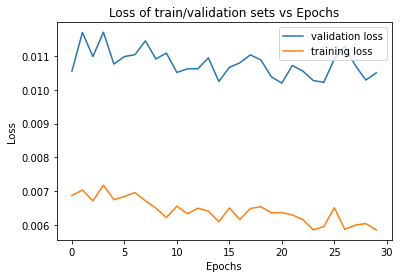

In [74]:
plot_model(history)

In [75]:
comb_model.evaluate([test_x_img_gray,test_x],test_y)

1069/1069 [==============================] - 0s 79us/sample - loss: 0.0132


0.013197349311245502

In [76]:
test_y.iloc[[74,31,23,426,200]]*max_price

1089     300000.0
448      998000.0
375     1150000.0
6251     490000.0
2919     999999.0
Name: price, dtype: float64

In [77]:
comb_model.predict([test_x_img_gray,test_x])[[74,31,23,426,200]]*max_price

array([[ 410504.34],
       [1170049.1 ],
       [ 698328.75],
       [ 504365.22],
       [1062696.9 ]], dtype=float32)

In [78]:
model_1.predict(test_x)[[74,31,23,426,200]]*max_price

array([[ 321093.7 ],
       [1033967.1 ],
       [ 670869.75],
       [ 542481.8 ],
       [1146654.6 ]], dtype=float32)

In [79]:
model_1.save_weights("best_model_weights(fc).h5")
model_1.save("best_model_MODEL(fc).h5")